<a href="https://colab.research.google.com/github/MeikoFudo/MeikoFudo/blob/main/EEG_state_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import xgboost as xgb
import lightgbm as ltb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

Считаем csv файл с данными и выведем первые 5 строчек датафрейма .

In [3]:
df = pd.read_csv('mental-state.csv')
df.head()

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,...,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,25.781648,33.836367,-92.769629,19.187957,-1.542262,0.197462,-119.561133,2.032654,21.596272,33.965587,...,0.000230,0.000351,0.000547,0.000381,0.000350,0.000453,0.000442,0.000325,0.000209,2.0
1,29.357891,26.792566,417.203910,19.472121,-38.797263,-16.897194,-29.368531,-9.055370,44.647424,40.893307,...,0.001671,0.000740,0.001122,0.000521,0.000624,0.000439,0.001249,0.000727,0.000801,2.0
2,28.451926,31.076434,72.231301,14.245938,-13.225057,-0.614138,-28.331698,-8.858742,31.450289,30.692883,...,0.000748,0.000569,0.000327,0.000197,0.000833,0.000909,0.000699,0.001165,0.000616,2.0
3,21.282184,19.985184,16.220094,39.787312,1.847866,0.670216,-1.820355,20.220724,21.404679,20.777411,...,0.000990,0.005644,0.006891,0.010546,0.009583,0.011158,0.008853,0.004551,0.002287,1.0
4,20.431516,28.982168,27.540246,19.960398,2.491458,-6.020503,-1.071166,2.655259,16.295039,32.658163,...,0.001659,0.014379,0.014492,0.002949,0.004575,0.008305,0.007202,0.006957,0.009836,2.0


Выведем график, чтобы посмотреть распределение данных временного ряда.

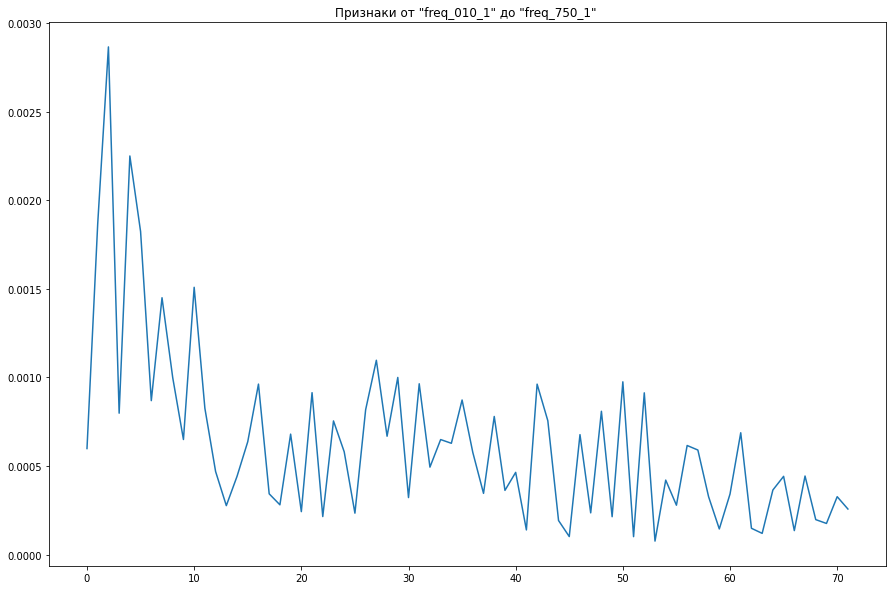

In [23]:
sampling = df.loc[0,'freq_010_1':'freq_750_1']
plt.figure(figsize=(15,10))
plt.plot(range(len(sampling)),sampling)
plt.title('Признаки от "freq_010_1" до "freq_750_1" ')
plt.show()

Выведем информацию о датафрейме.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Columns: 989 entries, lag1_mean_0 to Label
dtypes: float64(989)
memory usage: 4.1 MB


Выведем распределение значений данных целевой переменной . Данные распределены достаточно равномерно, можно использовать метрику accuracy, так как не наблюдается дисбаланс классов.

In [ ]:
df['Label'].value_counts()

2.0    193
1.0    184
0.0    171
Name: Label, dtype: int64

Удалим нулевые значения в датафрейме, если такие имеются, и выделим стобец с целевыми значениями в отдельную переменную.

In [5]:
df = df.dropna()
y = df['Label'].copy()
X = df.drop('Label', axis=1).copy()

Выполним разбиение данных на тестовую и тренировочную выборки. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Отберем параметры для последующего перебора по сетке и внесем их в словарь. (Набор параметров взять очень ограниченный, ибо выдающимися вычислительными способностями не распологаю).

In [28]:
parameters = {
    'max_depth': range (4, 6, 1),
    'n_estimators': range(60, 100, 40),
    'learning_rate': [0.2, 0.01],
    'alpha':[10],
    'lambda':[8]
}

In [8]:
model_xgb = xgb.XGBClassifier()

Осуществим перебор по сетке для выделения лучших параметров из словаря parameters.

In [26]:
grid_search_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv= 10,
    verbose=2
)

Обучим модель.

In [27]:
grid_search_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'alpha': [10], 'lambda': [8],
                         'learning_rate': [0.2, 0.01], 'max_depth': range(4, 6),
                         'n_estimators': range(60, 220, 40)},
             scoring='roc_auc', verbose=2)

In [29]:
y_predict_xgb = grid_search_xgb.predict(X_test)

Осуществим кросс-валидацию и усредним значения, после выведем результат по метрике accuracy.

In [ ]:
scores_xgb = cross_val_score(grid_search_xgb, X, y, cv=5, scoring='accuracy')
print('Accuracy for xgb with cross validaation:', scores_xgb.mean())

Fitting 10 folds for each of 16 candidates, totalling 160 fits


Проделаем эти действия для модели Lightboost, только без подбора параметров, параметры будут определяться по умолчаю.

In [10]:
model_ltb = ltb.LGBMClassifier()

In [13]:
model_ltb.fit(X_train, y_train)

LGBMClassifier()

In [14]:
y_predict_ltb = model_ltb.predict(X_test)

In [15]:
scores_ltb = cross_val_score(model_ltb, X, y, cv=5, scoring='accuracy')
print('Accuracy for ltb with cross validaation:', scores_ltb.mean())

Accuracy for ltb with cross validaation: 0.9576271186440678


Обучим так же Random Forest для этой задачи.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
param_rf = {'bootstrap': [True],
 'max_depth': [10],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400]}
rf_random = RandomizedSearchCV(estimator = model_random_forest, param_distributions = param_rf , n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True], 'max_depth': [10],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   random_state=42, verbose=2)

In [19]:
y_predict_rf = rf_random.predict(X_test)

Пройдемся по данным кросс-валидацией с разбиением равным 5 и усредним значения.

In [21]:
scores_rf = cross_val_score(rf_random, X, y, cv=5, scoring='accuracy')
print('Accuracy for ltb with cross validaation:', scores_rf.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Accuracy for ltb with cross validaation: 0.9542372881355933
